In [1]:
import os,sys,glob
sys.path.append("..")
from py.utils_002_update import *
from py.utils_999_jupyter210922 import *
# sys.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


START...Now is -> 2021-09-23 12:04:36.106615
START...Now is -> 2021-09-23 12:04:36.169286


In [2]:
# check_category(col="name17")
# DIR_CHEMI="/Users/soriiieee/work2/stock/out/ts1/name33/化学"
# DIR_CAR="/Users/soriiieee/work2/stock/out/ts1/name33/輸送用機器"

def get_FilesPath(cate,name, isFNAME=False):
    DIR=f"/Users/soriiieee/work2/stock/out/ts1/{cate}/{name}"
    if os.path.exists(DIR):
        print("OK !")
    else:
        print("Not Found !")
        sys.exit()
    _path = sorted(glob.glob(f"{DIR}/*.csv"))
    if isFNAME:
        _f = [ os.path.basename(p) for p in _path]
        return _f
    else:
        return _path

# get_FilesPath("name33","輸送用機器", isFNAME=True)

In [3]:
def get_stock_path(key,st=None,ed=None):
    _path = get_FilesPath("name33","輸送用機器", isFNAME=False)
    path = [ p for p in _path if key in p] [0]
    df = load_df(path)
    if st:
        df = cut_time(df,st=st,ed=ed)
    return df


df = get_stock_path("デンソー",st=datetime(2018,1,1,0,0),ed=datetime(2020,1,1,0,0))

OK !


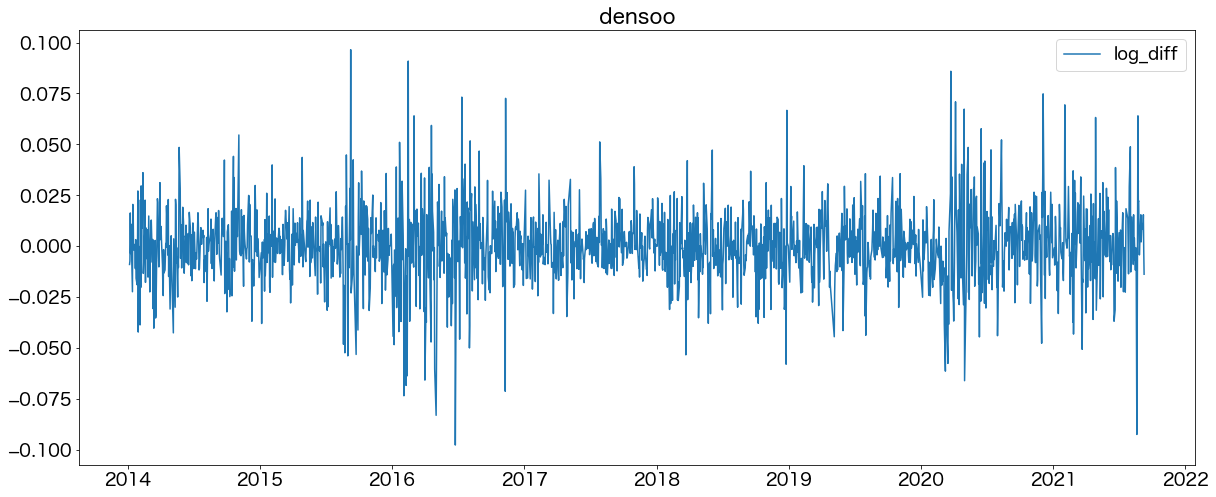

In [19]:
# df.head()
c = "log_diff"
def cut_range(df,_range):
    if "time" not in df.columns:
        df = df.reset_index()
    if df["time"].dtypes ==object:
        df["time"] = pd.to_datetime(df["time"])
    _df=[]
    for t_range in _range:
        if t_range=="all":
            _df.append(df)
        else:
            _df.append(df[(df["time"]>=t_range[0])&(df["time"]<=t_range[1])])
    return _df

title=convert_roma("デンソー")
plot(df,_col=[c], title=title)

In [20]:
df.head()

,open,close,high,low,diff_max,diff_day,volume,log_diff
time,,,,,,,,
2014-01-06,5540.0,5500.0,5540.0,5460.0,80.0,-40.0,2820100.0,-0.0090
2014-01-07,5450.0,5460.0,5530.0,5390.0,140.0,10.0,3187700.0,-0.0073
2014-01-08,5470.0,5550.0,5570.0,5470.0,100.0,80.0,1638900.0,0.0163
2014-01-09,5510.0,5530.0,5570.0,5490.0,80.0,20.0,1930500.0,-0.0036
2014-01-10,5540.0,5590.0,5650.0,5520.0,130.0,50.0,2962000.0,0.0108


In [31]:
def plot_self_acf(df,c,lag=50):
    f,ax =  plt.subplots(2,1,figsize=(12,18))
    sm.graphics.tsa.plot_acf(df[c], lags=lag, ax=ax[0])
    sm.graphics.tsa.plot_pacf(df[c], lags=lag, ax=ax[1])
    
    for i,title in enumerate(["acf","pacf"]):
        ax[i].set_title(title)
        ax[i].set_xticks(np.arange(lag))
        ax[i].set_xlim(0,lag)
        ax[i].set_ylim(-0.5,0.5)
        ax[i].grid()
    plt.show()
    return 

In [49]:
df = get_stock_path("デンソー",st=datetime(2014,1,1,0,0),ed=datetime(2021,9,10,0,0))
# print(df.shape)
_range = [
    [datetime(2014,1,1,0,0),datetime(2016,1,1,0,0)],
    [datetime(2015,1,1,0,0),datetime(2017,1,1,0,0)],
    [datetime(2016,1,1,0,0),datetime(2018,1,1,0,0)],
    [datetime(2018,1,1,0,0),datetime(2020,1,1,0,0)],
    [datetime(2019,9,1,0,0),datetime(2021,9,1,0,0)],
]
_df = cut_range(df,_range)

OK !


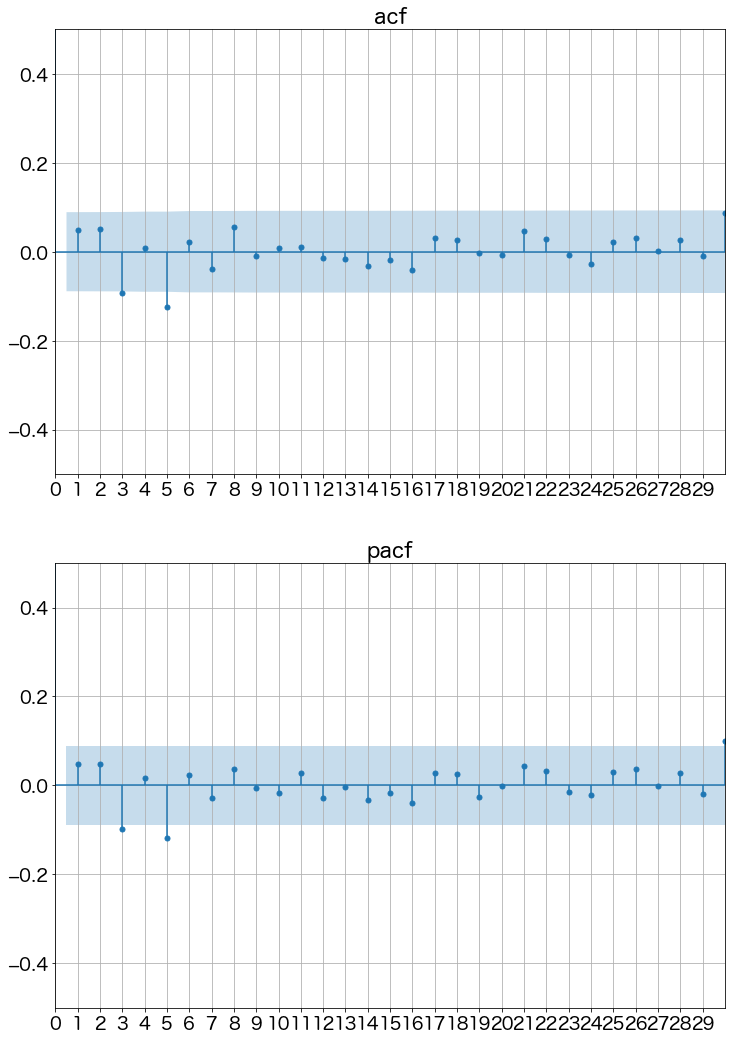

In [50]:
c = "log_diff"
plot_self_acf(_df[4],c,lag=30)

In [51]:
#時系列分析　－＞ARMA
# https://qiita.com/cleeeear/items/49628a4727f79bd074e0
# AR,MA,ARMA -> について簡易的に紹介してくれるページについて
# https://qiita.com/eg_i_eg/items/94ea41edc96cbb3dca6a

#最適なorder = (AR,MA) の推定を行いたい時　
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html
# from statsmodels.tsa.arima_process import arma_generate_sample

#python でARMA
# https://analytics-note.xyz/time-series/statsmodels-arma/

c = "log_diff"
_m=[]
df = pd.concat([_df[0],_df[1]],axis=0)

def train_ARMA_loop(df,c):
    max_ar,max_ma = 4,4
    data = df[c].values
    _aic,_bic= [],[]
    _resid_c,_s = [],[]
    df_resd = pd.DataFrame()
    
    _model = []
    i=0
    for n_AR in range(0,max_ar):
        for n_MA in range(0,max_ma):
#             i+=1
            m = sm.tsa.ARMA(df[c].values,order=(n_AR,n_MA)).fit(trend="c", method="mle")
            _aic.append(m.aic)
            _bic.append(m.bic)
            df_resd[f"AR{n_AR}_MA{n_MA}"] = m.resid
            _resid_c.append(f"AR{n_AR}_MA{n_MA}")
#             _s.append(m.resid)
            print(f"AR{n_AR}_MA{n_MA} -> resid" , m.resid.shape[0])
            _model.append(m)
            i+=1
    
    df = pd.DataFrame()
    df["para"] = _resid_c
    df["aic"] = _aic
    df["bic"] = _bic
    
    return df,df_resd, _model

df_para,df_resd, _model= train_ARMA(df,c)

AR0_MA0 -> resid 977
AR0_MA1 -> resid 977
AR0_MA2 -> resid 977
AR0_MA3 -> resid 977
AR1_MA0 -> resid 977


/anaconda3/envs/sori_torch/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AR1_MA1 -> resid 977
AR1_MA2 -> resid 977
AR1_MA3 -> resid 977
AR2_MA0 -> resid 977
AR2_MA1 -> resid 977
AR2_MA2 -> resid 977
AR2_MA3 -> resid 977
AR3_MA0 -> resid 977
AR3_MA1 -> resid 977
AR3_MA2 -> resid 977
AR3_MA3 -> resid 977


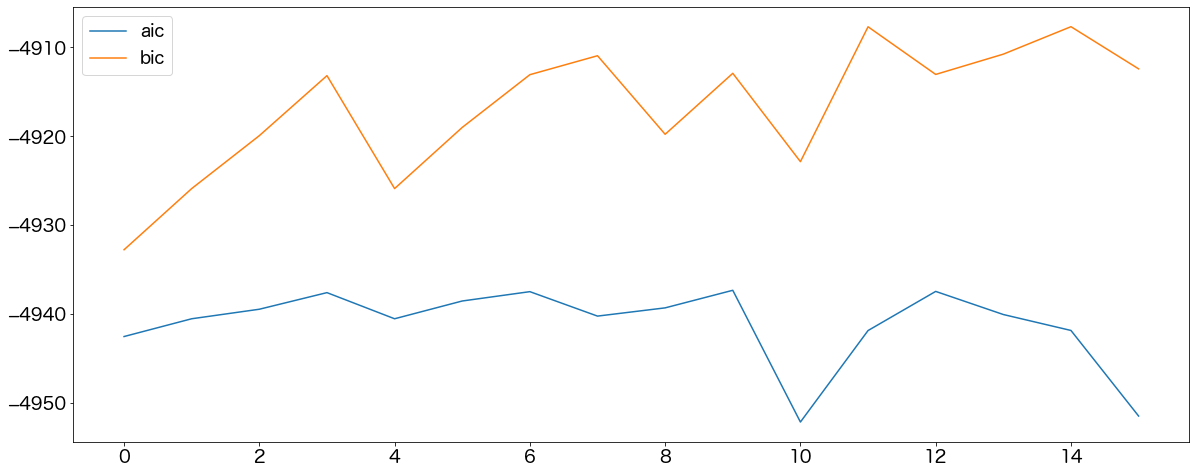

In [52]:
df_p2 = df_para.set_index("para")
plot(df_para,_col=["aic","bic"])
# df.set_index("para").plot()

In [53]:
df_para

,para,aic,bic
0,AR0_MA0,-4942.544610,-4932.775636
1,AR0_MA1,-4940.544632,-4925.891172
2,AR0_MA2,-4939.471925,-4919.933978
3,AR0_MA3,-4937.603066,-4913.180633
4,AR1_MA0,-4940.544633,-4925.891173
5,AR1_MA1,-4938.544633,-4919.006686
6,AR1_MA2,-4937.493442,-4913.071009
7,AR1_MA3,-4940.245123,-4910.938203
8,AR2_MA0,-4939.318049,-4919.780102
9,AR2_MA1,-4937.339601,-4912.917167


In [55]:
m = _model[10]
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  977
Model:                     ARMA(2, 2)   Log Likelihood                2482.084
Method:                           mle   S.D. of innovations              0.019
Date:                Thu, 23 Sep 2021   AIC                          -4952.168
Time:                        12:53:19   BIC                          -4922.861
Sample:                             0   HQIC                         -4941.017
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.851e-05      0.001     -0.111      0.912      -0.001       0.001
ar.L1.y       -0.4444      0.015    -30.397      0.000      -0.473      -0.416
ar.L2.y       -0.9511      0.014    -67.548      0.000      -0.979      -0.923
ma.L1.y        0.4365      0.007     66.654      0.000       0.424       0.449
ma.L2.y        0.9917      0.008    129.947      0.000       0.977       1.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2336           -0.9984j            1.0254           -0.2866
AR.2           -0.2336           +0.9984j            1.0254            0.2866
MA.1           -0.2201           -0.9798j            1.0042           -0.2852
MA.2           -0.2201           +0.9798j            1.0042            0.2852
-----------------------------------------------------------------------------
"""

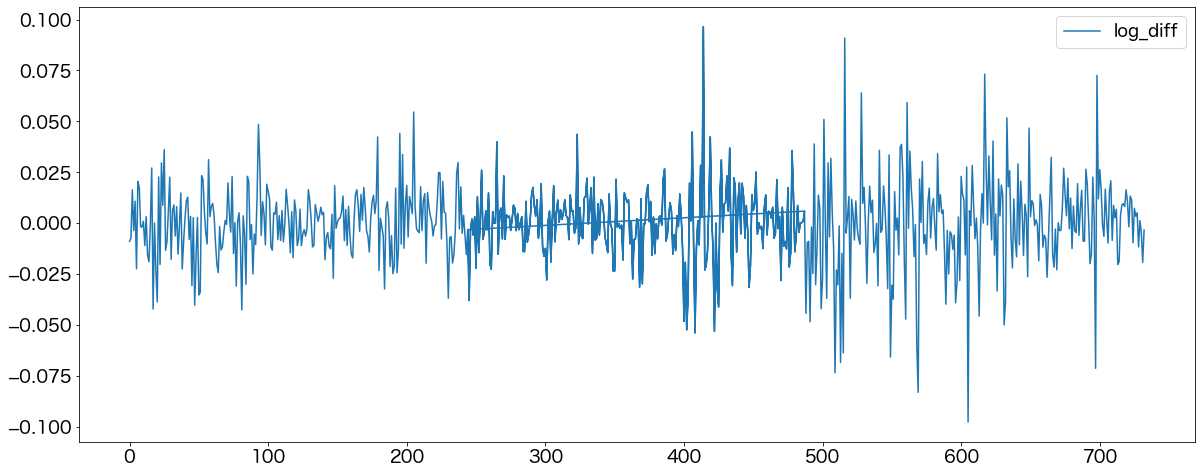

In [59]:
df.head()
df.tail()
plot(df,_col = ["log_diff"])

In [68]:
c = "log_diff"
train = get_stock_path("デンソー",st=datetime(2018,1,1,0,0),ed=datetime(2020,1,1,0,0))
test = get_stock_path("デンソー",st=datetime(2018,1,1,0,0),ed=datetime(2020,10,1,0,0))

print(train.shape, test.shape)
# m = sm.tsa.ARMA(train,order=(２,２)).fit(trend="c", method="mle")
# m.summary()
# train.head()

OK !
OK !
(501, 8) (681, 8)


,open,close,high,low,diff_max,diff_day,volume,log_diff
time,,,,,,,,
2018-01-02,6763.0,6763.0,6763.0,6763.0,0.0,0.0,0.0,0.0000
2018-01-03,6763.0,6763.0,6763.0,6763.0,0.0,0.0,0.0,0.0000
2018-01-04,6875.0,6925.0,6935.0,6865.0,70.0,50.0,1778800.0,0.0237
2018-01-05,6986.0,7073.0,7078.0,6965.0,113.0,87.0,1758700.0,0.0211
2018-01-08,7073.0,7073.0,7073.0,7073.0,0.0,0.0,0.0,0.0000


In [83]:
# m = sm.tsa.ARMA(df[c].values,order=(n_AR,n_MA)).fit(trend="c", method="mle")
m = sm.tsa.ARMA(train[c].values,order=(2,2)).fit(trend="c", method="mle")
y_pred = m.predict(502,681-2)
test2 = test.iloc[502:,:].
test2["log_diff_pred"] = y_pred

plot(test,_col = ["log_diff","log_diff_pred"])

ValueError: Length of values (179) does not match length of index (681)